# Table of Contents

<div class="alert alert-block alert-info">
    <ol start=5>
        <li>Model Selection and Building
            <ol style="list-style-type:none;padding-left:0">
                <li>5.1 Model Comparison Across Stages</li>
                <li>5.2 Pipeline</li>
                <li>5.3 Hyperparameter Optimization</li>
                <li>5.4 Final Model</li>
                <li>5.5 Submission File</li>
            </ol>
        </li>
    </ol>
</div>

<div id="modselbuild">
    <div style="font-size:25pt;font-weight:700;padding:20px 0;line-height:1.2">5. Model Selection and Building</div>
</div>

<div id="mcagstegs">
    <div style="font-size:20pt;font-weight:700;padding:20px 0;line-height:1.2">5.1 Model Comparison Across Stages</div>
</div>

In [1]:
from utils_ml import *

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
df.duplicated().sum().sum()

0

In [5]:
datetime_transformer = DateTimeTransformer()
df = datetime_transformer.transform(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype   
---  ------                    --------------    -----   
 0   id                        1458644 non-null  object  
 1   vendor_id                 1458644 non-null  int64   
 2   passenger_count           1458644 non-null  int64   
 3   pickup_longitude          1458644 non-null  float64 
 4   pickup_latitude           1458644 non-null  float64 
 5   dropoff_longitude         1458644 non-null  float64 
 6   dropoff_latitude          1458644 non-null  float64 
 7   store_and_fwd_flag        1458644 non-null  object  
 8   trip_duration             1458644 non-null  int64   
 9   pickup_datetime_year      1458644 non-null  int64   
 10  pickup_datetime_month     1458644 non-null  int64   
 11  pickup_datetime_hour      1458644 non-null  int64   
 12  pickup_datetime_weekday   1458644 non-null  object  
 13  pickup_datet

In [7]:
X = df.drop(columns="trip_duration", axis=1)
y = df["trip_duration"]

In [8]:
# train = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = rst)

In [9]:
print(f"training shapes: {X_train.shape}, {y_train.shape}")

training shapes: (1166915, 18), (1166915,)


In [10]:
df = pd.concat([X_train, y_train], axis=1)

In [11]:
print(f"train shape: {df.shape}")

train shape: (1166915, 19)


In [12]:
df.isnull().sum().sum()

0

In [13]:
columns_to_drop = ['id', 'pickup_datetime_year', 'dropoff_datetime_year',
                   'dropoff_datetime_month', 'dropoff_datetime_weekday', 
                   'dropoff_datetime_hour', 'dropoff_datetime_period']

In [14]:
df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1166915 entries, 1053743 to 121958
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype   
---  ------                   --------------    -----   
 0   vendor_id                1166915 non-null  int64   
 1   passenger_count          1166915 non-null  int64   
 2   pickup_longitude         1166915 non-null  float64 
 3   pickup_latitude          1166915 non-null  float64 
 4   dropoff_longitude        1166915 non-null  float64 
 5   dropoff_latitude         1166915 non-null  float64 
 6   store_and_fwd_flag       1166915 non-null  object  
 7   pickup_datetime_month    1166915 non-null  int64   
 8   pickup_datetime_hour     1166915 non-null  int64   
 9   pickup_datetime_weekday  1166915 non-null  object  
 10  pickup_datetime_period   1166915 non-null  category
 11  trip_duration            1166915 non-null  int64   
dtypes: category(1), float64(4), int64(5), object(2)
memory usage: 107.9+ MB


**Label Encoding**

In [16]:
df["pickup_datetime_weekday"] = df["pickup_datetime_weekday"].map({"Monday":1,"Tuesday":2,"Wednesday":3, 
                                                                   "Thursday":4, "Friday":5, "Saturday":6, 
                                                                   "Sunday":7}).astype("int")

**Dummy Encoding**

In [17]:
columns = ["vendor_id","store_and_fwd_flag", "pickup_datetime_period"]

In [18]:
df = pd.get_dummies(df, columns=columns, dtype=int, drop_first=True)

**Cyclical Encoding**

The reason I do not apply cyclical encoding to the `pickup_datetime_period` feature is that it is created using bins that categorize distinct parts of the day (Early Morning, Morning, Afternoon, Evening, Night). Each of these categories is qualitative and represents a segment of time rather than a continuous cycle. For instance, Early Morning does not directly transition into Night, nor does it imply a cyclical relationship.

The binning method I used creates distinct categories that do not wrap around; the periods are inherently separate. Therefore, applying cyclical encoding could mislead the model into interpreting a non-existent continuity among these categories.

In [19]:
df['hour_sin'] = np.sin(2 * np.pi * df['pickup_datetime_hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['pickup_datetime_hour'] / 24)

In [20]:
df['weekday_sin'] = np.sin(2 * np.pi * df['pickup_datetime_weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['pickup_datetime_weekday'] / 7)

In [21]:
df['month_sin'] = np.sin(2 * np.pi * df['pickup_datetime_month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['pickup_datetime_month'] / 12)

In [22]:
df.drop(columns=['pickup_datetime_hour', 'pickup_datetime_weekday', 'pickup_datetime_month'], axis=1, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1166915 entries, 1053743 to 121958
Data columns (total 18 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   passenger_count                   1166915 non-null  int64  
 1   pickup_longitude                  1166915 non-null  float64
 2   pickup_latitude                   1166915 non-null  float64
 3   dropoff_longitude                 1166915 non-null  float64
 4   dropoff_latitude                  1166915 non-null  float64
 5   trip_duration                     1166915 non-null  int64  
 6   vendor_id_2                       1166915 non-null  int32  
 7   store_and_fwd_flag_Y              1166915 non-null  int32  
 8   pickup_datetime_period_Morning    1166915 non-null  int32  
 9   pickup_datetime_period_Afternoon  1166915 non-null  int32  
 10  pickup_datetime_period_Evening    1166915 non-null  int32  
 11  pickup_datetime_period_Night    

In [24]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [25]:
print(f"training shapes: {X_train.shape}, {y_train.shape}")

training shapes: (1166915, 17), (1166915,)


**Train and Test the Baseline Model**

In [26]:
baseline_model = LinearRegression()

In [28]:
%%time
messages_0 = model_rmsle(baseline_model, X_train, y_train, 'Stage 0', percent_data='80')[0]

Stage 0, 80% Data, RMSLE for LinearRegression: 0.8644 (0.0042)
CPU times: total: 2.62 s
Wall time: 33.8 s


**Learning Curve the Baseline Model**

In [29]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 0', percent_data='80')


KeyboardInterrupt



**Graph Analysis**
- Initial Behavior (Left Side of the Graph, Small Training Sizes)
    - At the start (low training size), the cross-validation error is high but drops significantly as the training size increases. This indicates that the model initially struggles to generalize due to the small training data.
    - The training error is also relatively high and decreases sharply with more data, showing that the model initially underfits (it doesn’t capture patterns well).
- Mid-range Behavior (Middle of the Graph)
    - As the training size increases, the cross-validation and training errors converge more closely. This is a sign that the model is improving its generalization and benefiting from additional data.
    - Both the training and cross-validation errors stabilize around a similar value, suggesting a good balance between bias and variance.
- Final Behavior (Right Side of the Graph, Large Training Sizes)
    - At larger training sizes, the cross-validation error plateaus and even slightly increases, while the training error remains relatively stable.
    - The gap between the training and cross-validation scores is small, indicating that the model is not overfitting but rather reaching its capacity for improvement with the given data and linear regression approach.
    - The slight increase in cross-validation error at the end suggests that adding more data alone might not significantly improve performance and that the model's complexity may need to be increased to capture more patterns.

**Options for Improvement**
- Feature Engineering
    - Adding more relevant features or transforming existing features could help reduce the RMSLE and improve the model's performance.
- Try More Complex Models
    - Linear regression is a simple baseline. Trying models like decision trees or gradient boosting (e.g., XGBoost, LightGBM) might reduce the RMSLE further.
- Hyperparameter Tuning
    - Even for linear regression, tuning regularization parameters (like Ridge or Lasso) might help improve the fit.

**Comparison with Lasso and ElasticNet Models**

In [30]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [31]:
%%time
messages_0 = model_rmsle(models, X_train, y_train, 'Stage 0', percent_data='80')[0]

Stage 0, 80% Data, RMSLE for LR: 0.8644 (0.0042)
Stage 0, 80% Data, RMSLE for LASSO: 0.8638 (0.0034)
Stage 0, 80% Data, RMSLE for EN: 0.8867 (0.0024)
CPU times: total: 8.02 s
Wall time: 2min 25s


### Stage 1: Adding distance_osrm Feature

In [2]:
df = pd.read_csv("distance_osrm.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
 11  distance_osrm       1458627 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 133.5+ MB


In [4]:
df.duplicated().sum().sum()

0

In [5]:
datetime_transformer = DateTimeTransformer()
df = datetime_transformer.transform(df)

In [6]:
X = df.drop(columns="trip_duration", axis=1)
y = df["trip_duration"]

In [7]:
# train = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = rst)

In [8]:
df = pd.concat([X_train, y_train], axis=1)

In [9]:
df.isnull().sum().sum()

16

In [10]:
df.dropna(inplace=True)

In [11]:
df = transform_encoding(df)

In [12]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [13]:
baseline_model = LinearRegression()

In [14]:
%%time
messages_1 = model_rmsle(baseline_model, X_train, y_train, 'Stage 1', percent_data='80')[0]

Stage 1, 80% Data, RMSLE for LinearRegression: 0.6554 (0.0027)
CPU times: total: 2.62 s
Wall time: 1min 2s


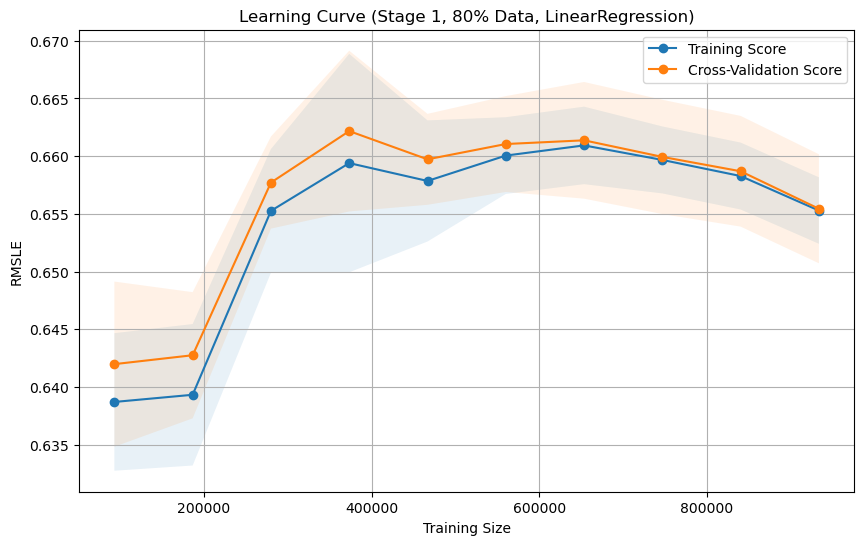

CPU times: total: 3.11 s
Wall time: 37.7 s


In [15]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 1', percent_data='80')

**Comparison with Lasso and ElasticNet Models**

In [16]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [17]:
%%time
messages_1 = model_rmsle(models, X_train, y_train, 'Stage 1', percent_data='80')[0]

Stage 1, 80% Data, RMSLE for LR: 0.6554 (0.0027)
Stage 1, 80% Data, RMSLE for LASSO: 0.6573 (0.0030)
Stage 1, 80% Data, RMSLE for EN: 0.6635 (0.0029)
CPU times: total: 8.06 s
Wall time: 1min 58s


### Stage 2: Adding speed_osrm Feature

In [18]:
df = pd.read_csv("distance_osrm.csv")

In [19]:
speed_calculator = SpeedCalculator()
df = speed_calculator.transform(df)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
 11  distance_osrm       1458627 non-null  float64
 12  speed_osrm          1458627 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 144.7+ MB


In [21]:
df.duplicated().sum().sum()

0

In [22]:
datetime_transformer = DateTimeTransformer()
df = datetime_transformer.transform(df)

In [23]:
X = df.drop(columns="trip_duration", axis=1)
y = df["trip_duration"]

In [24]:
# train = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = rst)

In [25]:
df = pd.concat([X_train, y_train], axis=1)

In [26]:
df.isnull().sum().sum()

32

In [27]:
df.dropna(inplace=True)

In [28]:
df = transform_encoding(df)

In [29]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [30]:
baseline_model = LinearRegression()

In [31]:
%%time
messages_2 = model_rmsle(baseline_model, X_train, y_train, 'Stage 2', percent_data='80')[0]

Stage 2, 80% Data, RMSLE for LinearRegression: 0.6235 (0.0028)
CPU times: total: 2.5 s
Wall time: 37.2 s


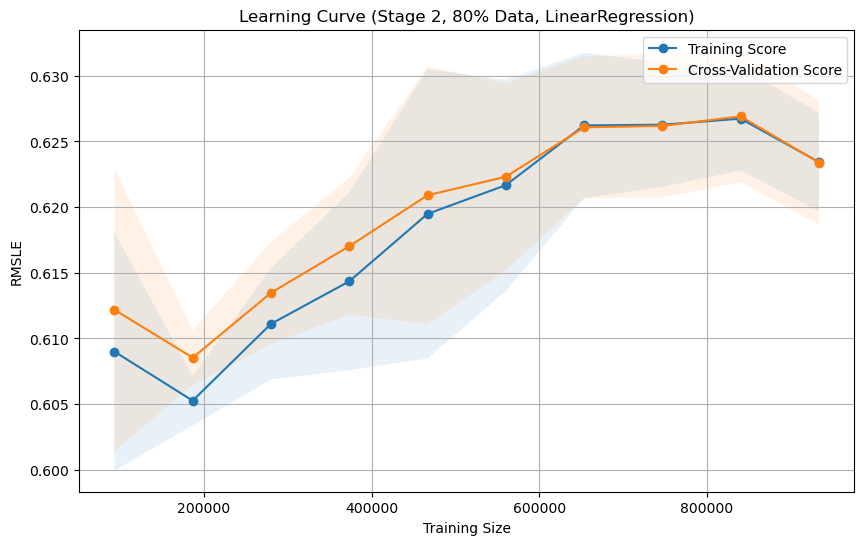

CPU times: total: 2.92 s
Wall time: 38.2 s


In [33]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 2', percent_data='80')

**Comparison with Lasso and ElasticNet Models**

In [34]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [35]:
%%time
messages_2 = model_rmsle(models, X_train, y_train, 'Stage 2', percent_data='80')[0]

Stage 2, 80% Data, RMSLE for LR: 0.6235 (0.0028)
Stage 2, 80% Data, RMSLE for LASSO: 0.6255 (0.0031)
Stage 2, 80% Data, RMSLE for EN: 0.6307 (0.0030)
CPU times: total: 7.69 s
Wall time: 1min 45s


### Stage 3: Restricting the boundary to within NYC

In [2]:
df = pd.read_csv('train_temp.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166915 entries, 0 to 1166914
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   id                        1166915 non-null  object 
 1   vendor_id                 1166915 non-null  int64  
 2   passenger_count           1166915 non-null  int64  
 3   pickup_longitude          1166915 non-null  float64
 4   pickup_latitude           1166915 non-null  float64
 5   dropoff_longitude         1166915 non-null  float64
 6   dropoff_latitude          1166915 non-null  float64
 7   store_and_fwd_flag        1166915 non-null  object 
 8   distance_osrm             1166899 non-null  float64
 9   speed_osrm                1166899 non-null  float64
 10  pickup_datetime_month     1166915 non-null  int64  
 11  pickup_datetime_hour      1166915 non-null  int64  
 12  pickup_datetime_weekday   1166915 non-null  object 
 13  pickup_datetime_period    1

In [4]:
%%time
nyc_boundary_transformer = NYCWithinBoundaryTransformer(nyc_zone_file='NYC Taxi Zones.geojson', buffer_distance=500)
df = nyc_boundary_transformer.fit_transform(df)

I have removed 0.22% of the data outside the NYC boundary from the pickup and dropoff points in the dataset.
CPU times: total: 1min 4s
Wall time: 1min 7s


In [5]:
df.isnull().sum().sum()

8

In [6]:
df.dropna(inplace=True)

In [7]:
df = transform_encoding(df)

In [8]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [9]:
baseline_model = LinearRegression()

In [10]:
%%time
messages_3 = model_rmsle(baseline_model, X_train, y_train, 'Stage 3', percent_data='80')[0]

Stage 3, 80% Data, RMSLE for LinearRegression: 0.6027 (0.0023)
CPU times: total: 2.59 s
Wall time: 55.2 s


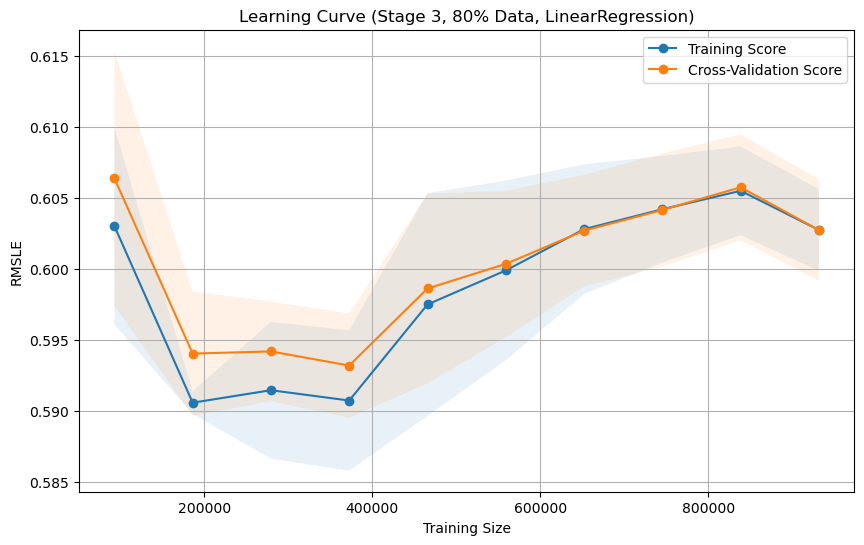

CPU times: total: 2.81 s
Wall time: 34.6 s


In [11]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 3', percent_data='80')

**Comparison with Lasso and ElasticNet Models**

In [12]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [13]:
%%time
messages_3 = model_rmsle(models, X_train, y_train, 'Stage 3', percent_data='80')[0]

Stage 3, 80% Data, RMSLE for LR: 0.6027 (0.0023)
Stage 3, 80% Data, RMSLE for LASSO: 0.6091 (0.0024)
Stage 3, 80% Data, RMSLE for EN: 0.6139 (0.0025)
CPU times: total: 7.52 s
Wall time: 1min 48s


### Stage 4a: Applying sensible restrictions to trip_duration, speed_osrm, and distance_osrm

In [14]:
df = pd.read_csv('train_temp.csv')

In [15]:
%%time
nyc_boundary_transformer = NYCWithinBoundaryTransformer(nyc_zone_file='NYC Taxi Zones.geojson', buffer_distance=500)
df = nyc_boundary_transformer.fit_transform(df)

I have removed 0.22% of the data outside the NYC boundary from the pickup and dropoff points in the dataset.
CPU times: total: 1min 20s
Wall time: 1min 26s


In [16]:
# minimum trip duration = 60 seconds
df = df[df["trip_duration"] >= 60]

In [17]:
df.isnull().sum().sum()

2

In [18]:
df.dropna(inplace=True)

In [19]:
df = transform_encoding(df)

In [20]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [21]:
baseline_model = LinearRegression()

In [22]:
%%time
messages_4a = model_rmsle(baseline_model, X_train, y_train, 'Stage 4a', percent_data='80')[0]

Stage 4a, 80% Data, RMSLE for LinearRegression: 1.5548 (0.0191)
CPU times: total: 2.56 s
Wall time: 36.6 s


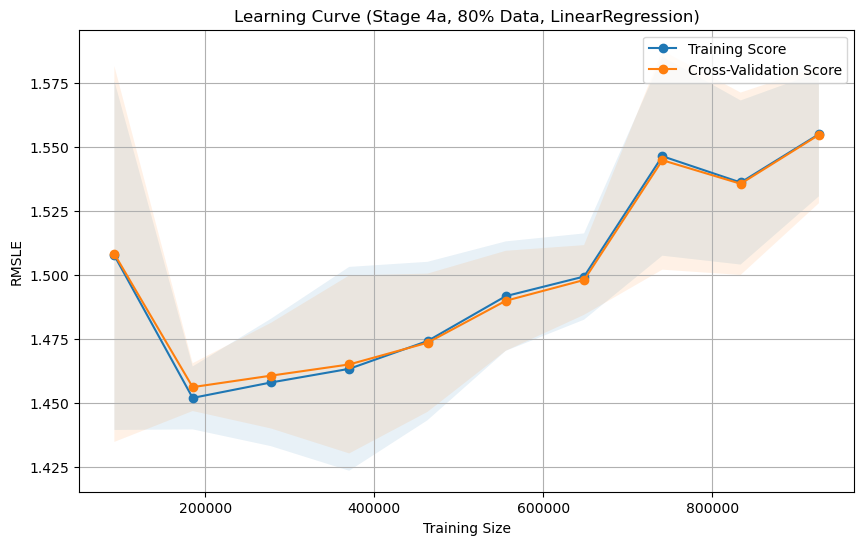

CPU times: total: 2.75 s
Wall time: 34.8 s


In [23]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 4a', percent_data='80')

**Comparison with Lasso and ElasticNet Models**

In [24]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [25]:
%%time
messages_4a = model_rmsle(models, X_train, y_train, 'Stage 4a', percent_data='80')[0]

Stage 4a, 80% Data, RMSLE for LR: 1.5548 (0.0191)
Stage 4a, 80% Data, RMSLE for LASSO: 1.5478 (0.0201)
Stage 4a, 80% Data, RMSLE for EN: 1.4725 (0.0196)
CPU times: total: 7.48 s
Wall time: 2min 27s


I observed a sharp increase in the RMSLE (Root Mean Squared Logarithmic Error) when I applied a restriction on the minimum trip duration. This increase is largely due to how RMSLE behaves when dealing with small values.

In [26]:
print(messages_3)
print(messages_4a)

Stage 3, 80% Data, RMSLE for LR: 0.6027 (0.0023)
Stage 3, 80% Data, RMSLE for LASSO: 0.6091 (0.0024)
Stage 3, 80% Data, RMSLE for EN: 0.6139 (0.0025)
Stage 4a, 80% Data, RMSLE for LR: 1.5548 (0.0191)
Stage 4a, 80% Data, RMSLE for LASSO: 1.5478 (0.0201)
Stage 4a, 80% Data, RMSLE for EN: 1.4725 (0.0196)


**Why RMSLE Increases with Minimum Trip Duration Restriction?**

* Effect of Small Values on RMSLE:
    - RMSLE penalizes under-predictions for smaller values more severely than for larger ones. This happens because the logarithmic transformation, which RMSLE uses, compresses the range for larger values but keeps smaller values more sensitive. When I removed trips with short durations (such as those less than 60 seconds), I likely eliminated a substantial portion of the trips with lower durations. These short trips could have been predicted more accurately by the model, which would have contributed to lowering the RMSLE score. By removing them, I essentially removed data points that could have helped the model perform better on small values.
* Imbalance in Data:
    - By filtering out these shorter trips, I also changed the distribution of the target variable, `trip_duration`. Trips shorter than 60 seconds might represent a significant part of the dataset. When I removed them, the model became biased toward longer trips, which caused it to perform worse overall because the model was trained on one distribution and then evaluated on a different one. This shift impacts the model's ability to generalize well across the data.
* Logarithmic Transformation Impact:
    - Because RMSLE compares the logarithm of actual values and predicted values, removing small trip durations compresses the range of values toward larger ones. As a result, the model’s errors on longer trips become relatively larger when measured on this compressed logarithmic scale. This further increases the RMSLE score after the filtering.

### Stage 4b: Stage 3 with Log Transformation

In [27]:
df = pd.read_csv('train_temp.csv')

In [28]:
%%time
nyc_boundary_transformer = NYCWithinBoundaryTransformer(nyc_zone_file='NYC Taxi Zones.geojson', buffer_distance=500)
df = nyc_boundary_transformer.fit_transform(df)

I have removed 0.22% of the data outside the NYC boundary from the pickup and dropoff points in the dataset.
CPU times: total: 1min 1s
Wall time: 1min 4s


In [29]:
df.isnull().sum().sum()

8

In [30]:
df.dropna(inplace=True)

In [31]:
# log(1 + trip_duration) to handle zero values
df['log_trip_duration'] = np.log1p(df['trip_duration'])

In [32]:
df.drop("trip_duration", axis=1, inplace=True)

In [33]:
df.rename(columns={'log_trip_duration': 'trip_duration'}, inplace=True)

In [34]:
df = transform_encoding(df)

In [35]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [36]:
baseline_model = LinearRegression()

In [37]:
%%time
messages_4b = model_rmsle(baseline_model, X_train, y_train, 'Stage 4b', percent_data='80', transform = 'log_transform')[0]

Stage 4b, 80% Data, RMSLE for LinearRegression: 0.5715 (0.0027)
CPU times: total: 2.2 s
Wall time: 35.5 s


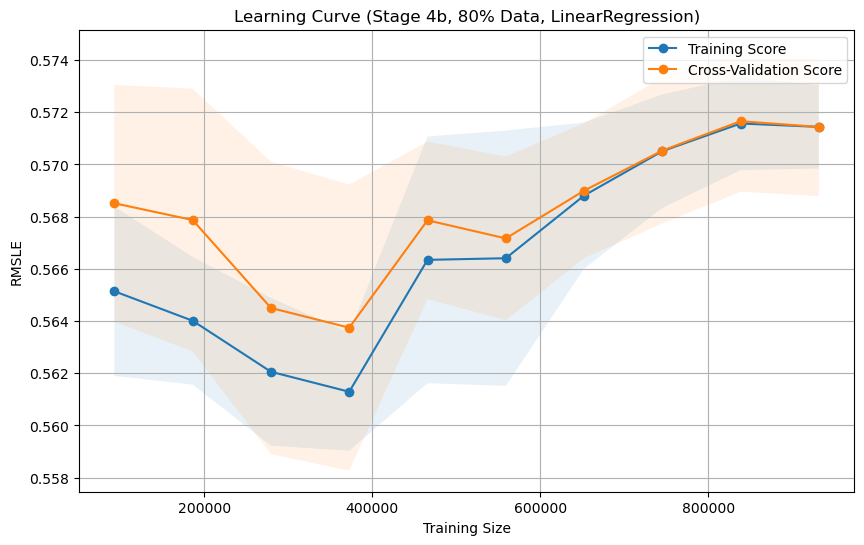

CPU times: total: 2.77 s
Wall time: 37 s


In [38]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 4b', percent_data='80', transform = 'log_transform')

**Comparison with Lasso and ElasticNet Models**

In [39]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [40]:
%%time
messages_4b = model_rmsle(models, X_train, y_train, 'Stage 4b', percent_data='80', transform = 'log_transform')[0]

Stage 4b, 80% Data, RMSLE for LR: 0.5715 (0.0027)
Stage 4b, 80% Data, RMSLE for LASSO: 0.6325 (0.0026)
Stage 4b, 80% Data, RMSLE for EN: 0.6070 (0.0028)
CPU times: total: 7.2 s
Wall time: 1min 14s


### Stage 4c: Applying sensible restrictions to trip_duration, speed_osrm, and distance_osrm with Log Transformation

In [41]:
df = pd.read_csv('train_temp.csv')

In [42]:
%%time
nyc_boundary_transformer = NYCWithinBoundaryTransformer(nyc_zone_file='NYC Taxi Zones.geojson', buffer_distance=500)
df = nyc_boundary_transformer.fit_transform(df)

I have removed 0.22% of the data outside the NYC boundary from the pickup and dropoff points in the dataset.
CPU times: total: 1min 5s
Wall time: 1min 8s


In [43]:
# minimum trip duration = 60 seconds
df = df[df["trip_duration"] >= 60]

In [44]:
df.isnull().sum().sum()

2

In [45]:
df.dropna(inplace=True)

In [46]:
# log(1 + trip_duration) to handle zero values
df['log_trip_duration'] = np.log1p(df['trip_duration'])

In [47]:
df.drop("trip_duration", axis=1, inplace=True)

In [48]:
df.rename(columns={'log_trip_duration': 'trip_duration'}, inplace=True)

In [49]:
df = transform_encoding(df)

In [50]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [51]:
baseline_model = LinearRegression()

In [52]:
%%time
messages_4c = model_rmsle(baseline_model, X_train, y_train, 'Stage 4c', percent_data='80', transform = 'log_transform')[0]

Stage 4c, 80% Data, RMSLE for LinearRegression: 0.4392 (0.0027)
CPU times: total: 2.36 s
Wall time: 32.5 s


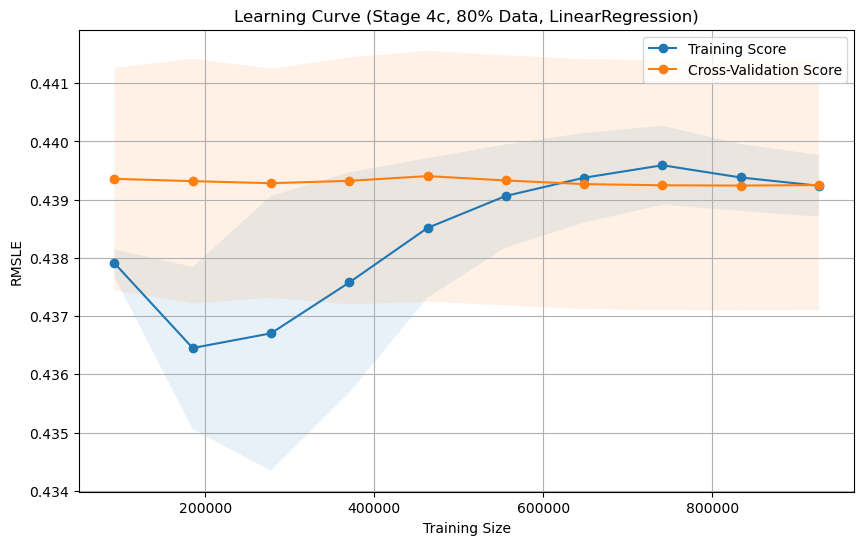

CPU times: total: 2.58 s
Wall time: 32.1 s


In [53]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 4c', percent_data='80', transform = 'log_transform')

**Comparison with Lasso and ElasticNet Models**

In [54]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [55]:
%%time
messages_4c = model_rmsle(models, X_train, y_train, 'Stage 4c', percent_data='80', transform = 'log_transform')[0]

Stage 4c, 80% Data, RMSLE for LR: 0.4392 (0.0027)
Stage 4c, 80% Data, RMSLE for LASSO: 0.5520 (0.0027)
Stage 4c, 80% Data, RMSLE for EN: 0.4838 (0.0027)
CPU times: total: 7.42 s
Wall time: 1min 15s


### Stage 4d: Final Result - Applying sensible restrictions to trip_duration, speed_osrm, and distance_osrm with Log Transformation

In [56]:
df = pd.read_csv('train_temp.csv')

In [57]:
%%time
nyc_boundary_transformer = NYCWithinBoundaryTransformer(nyc_zone_file='NYC Taxi Zones.geojson', buffer_distance=500)
df = nyc_boundary_transformer.fit_transform(df)

I have removed 0.22% of the data outside the NYC boundary from the pickup and dropoff points in the dataset.
CPU times: total: 1min 3s
Wall time: 1min 4s


In [58]:
%%time
restrictor = RestrictDurationSpeedDistance()
df = restrictor.transform(df)

I have removed 2.29% of the outliers from the dataset.
Max trip_duration = 20400
Min trip_duration = 60
Max distance_osrm = 55.28
Min distance_osrm = 0.10
Max speed_osrm = 149.79
Min speed_osrm = 5.00
CPU times: total: 1.67 s
Wall time: 1.79 s


In [59]:
df.isnull().sum().sum()

0

In [60]:
transformer = LogTripDurationTransformer()
df = transformer.transform(df)

In [61]:
df = transform_encoding(df)

In [62]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [63]:
baseline_model = LinearRegression()

In [64]:
%%time
messages_4d = model_rmsle(baseline_model, X_train, y_train, 'Stage 4d', percent_data='80', transform = 'log_transform')[0]

Stage 4d, 80% Data, RMSLE for LinearRegression: 0.4025 (0.0012)
CPU times: total: 1.84 s
Wall time: 31.2 s


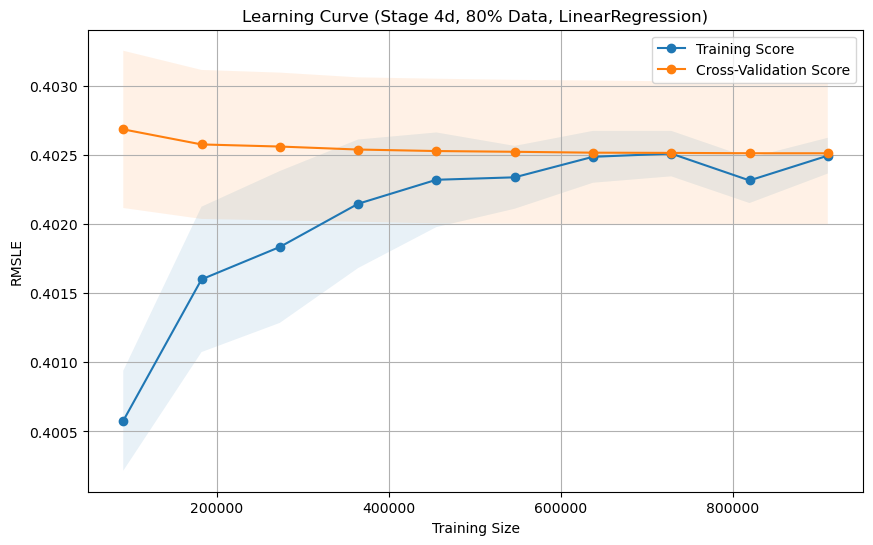

CPU times: total: 2.02 s
Wall time: 33.6 s


In [65]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 4d', percent_data='80', transform = 'log_transform')

**Comparison with Lasso and ElasticNet Models**

In [66]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [67]:
%%time
messages_4d = model_rmsle(models, X_train, y_train, 'Stage 4d', percent_data='80', transform = 'log_transform')[0]

Stage 4d, 80% Data, RMSLE for LR: 0.4025 (0.0012)
Stage 4d, 80% Data, RMSLE for LASSO: 0.5244 (0.0014)
Stage 4d, 80% Data, RMSLE for EN: 0.4493 (0.0011)
CPU times: total: 5.84 s
Wall time: 1min 10s


### Stage 5: Replacing pickup_longitude, pickup_latitude with pickup_cluster and dropoff_longitude, dropoff_latitude with dropoff_cluster

In [68]:
df = pd.read_csv('train_temp4.csv')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137661 entries, 0 to 1137660
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   vendor_id                1137661 non-null  int64  
 1   passenger_count          1137661 non-null  int64  
 2   store_and_fwd_flag       1137661 non-null  object 
 3   distance_osrm            1137661 non-null  float64
 4   speed_osrm               1137661 non-null  float64
 5   pickup_datetime_month    1137661 non-null  int64  
 6   pickup_datetime_hour     1137661 non-null  int64  
 7   pickup_datetime_weekday  1137661 non-null  object 
 8   pickup_datetime_period   1137661 non-null  object 
 9   trip_duration            1137661 non-null  int64  
 10  pickup_cluster           1137661 non-null  int64  
 11  dropoff_cluster          1137661 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 104.2+ MB


In [70]:
df.isnull().sum().sum()

0

In [71]:
transformer = LogTripDurationTransformer()
df = transformer.transform(df)

In [72]:
df = transform_encoding(df, 2)

In [73]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [74]:
baseline_model = LinearRegression()

In [75]:
%%time
messages_5 = model_rmsle(baseline_model, X_train, y_train, 'Stage 5', percent_data='80', transform = 'log_transform')[0]

Stage 5, 80% Data, RMSLE for LinearRegression: 0.3952 (0.0014)
CPU times: total: 1.88 s
Wall time: 33.3 s


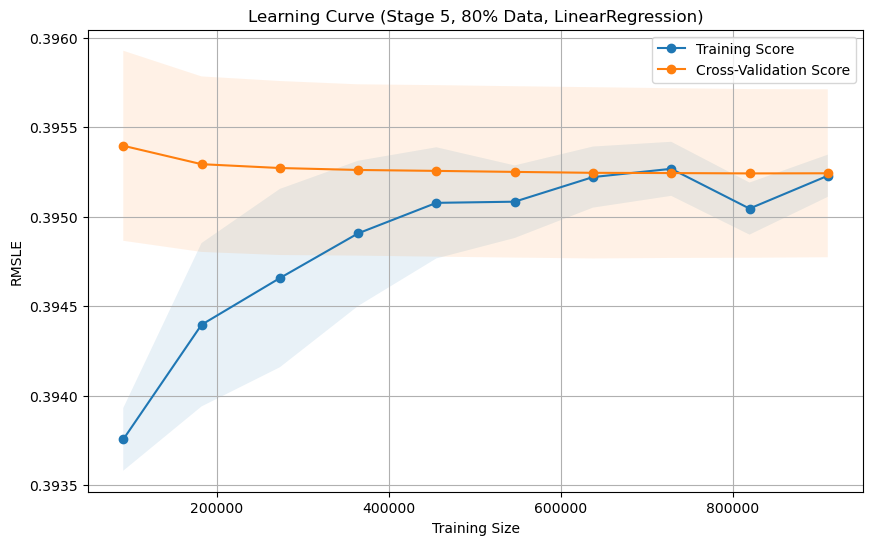

CPU times: total: 1.8 s
Wall time: 31.1 s


In [76]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 5', percent_data='80', transform = 'log_transform')

**Comparison with Lasso and ElasticNet Models**

In [77]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [78]:
%%time
messages_5 = model_rmsle(models, X_train, y_train, 'Stage 5', percent_data='80', transform = 'log_transform')[0]

Stage 5, 80% Data, RMSLE for LR: 0.3952 (0.0014)
Stage 5, 80% Data, RMSLE for LASSO: 0.5244 (0.0014)
Stage 5, 80% Data, RMSLE for EN: 0.4493 (0.0011)
CPU times: total: 5.98 s
Wall time: 1min 10s


### Stage 6: Skewness Transformation

In [79]:
dtype_columns = {
    'vendor_id': 'object',
    'pickup_datetime_month': 'object',
    'pickup_datetime_hour': 'object',
    'pickup_cluster': 'object',
    'dropoff_cluster': 'object'
}

In [80]:
df = pd.read_csv('train_temp5.csv', dtype=dtype_columns)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137661 entries, 0 to 1137660
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   vendor_id                1137661 non-null  object 
 1   passenger_count          1137661 non-null  int64  
 2   store_and_fwd_flag       1137661 non-null  object 
 3   distance_osrm            1137661 non-null  float64
 4   speed_osrm               1137661 non-null  float64
 5   pickup_datetime_month    1137661 non-null  object 
 6   pickup_datetime_hour     1137661 non-null  object 
 7   pickup_datetime_weekday  1137661 non-null  object 
 8   pickup_datetime_period   1137661 non-null  object 
 9   trip_duration            1137661 non-null  int64  
 10  pickup_cluster           1137661 non-null  object 
 11  dropoff_cluster          1137661 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 104.2+ MB


In [82]:
df.isnull().sum().sum()

0

The skewness values for the variables are as follows: `passenger_count` has a skewness of 2.1, `distance_osrm` has a skewness of 2.9, `speed_osrm` has a skewness of 1.8, and `trip_duration` has a notably high skewness of 25.4. All these variables exhibit severe skewness, as indicated by skewness values greater than 1 or less than -1. This suggests that transformations should be applied to these variables to reduce skewness and enhance normality in the data distribution.


In [83]:
skewness = df.skew(numeric_only=True)
print(skewness)

passenger_count    2.129746
distance_osrm      2.931195
speed_osrm         1.829935
trip_duration      2.314272
dtype: float64


**Box-Cox Transformation**

In [84]:
# Adding a small constant (+1) to handle zeros -> Remember this for interpretation
df['adjusted_passenger_count'] = df['passenger_count'] + 1

df['boxcox_passenger_count'], lambda_passenger = stats.boxcox(df['adjusted_passenger_count'])

**Log Transformation**

In [85]:
# log(1 + x) to handle zero values
df['log_trip_duration'] = np.log1p(df['trip_duration'])
df['log_distance_osrm'] = np.log1p(df['distance_osrm'])
df['log_speed_osrm'] = np.log1p(df['speed_osrm'])

In [86]:
df.drop(["trip_duration", "adjusted_passenger_count", "passenger_count", "distance_osrm", "speed_osrm"], axis=1, inplace=True)

In [87]:
df.rename(columns={'log_trip_duration': 'trip_duration'}, inplace=True)
df.rename(columns={'boxcox_passenger_count': 'passenger_count'}, inplace=True)
df.rename(columns={'log_distance_osrm': 'distance_osrm'}, inplace=True)
df.rename(columns={'log_speed_osrm': 'speed_osrm'}, inplace=True)

In [88]:
skewness = df.skew(numeric_only=True)
print(skewness)

passenger_count    0.709883
trip_duration     -0.125278
distance_osrm      0.958803
speed_osrm         0.207874
dtype: float64


In [89]:
cols_to_convert = ['vendor_id', 'pickup_datetime_month', 'pickup_datetime_hour', 
                      'pickup_cluster', 'dropoff_cluster']

In [90]:
df[cols_to_convert] = df[cols_to_convert].astype('Int64')

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137661 entries, 0 to 1137660
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   vendor_id                1137661 non-null  Int64  
 1   store_and_fwd_flag       1137661 non-null  object 
 2   pickup_datetime_month    1137661 non-null  Int64  
 3   pickup_datetime_hour     1137661 non-null  Int64  
 4   pickup_datetime_weekday  1137661 non-null  object 
 5   pickup_datetime_period   1137661 non-null  object 
 6   pickup_cluster           1137661 non-null  Int64  
 7   dropoff_cluster          1137661 non-null  Int64  
 8   passenger_count          1137661 non-null  float64
 9   trip_duration            1137661 non-null  float64
 10  distance_osrm            1137661 non-null  float64
 11  speed_osrm               1137661 non-null  float64
dtypes: Int64(5), float64(4), object(3)
memory usage: 109.6+ MB


In [92]:
df = transform_encoding(df, 2)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137661 entries, 0 to 1137660
Data columns (total 21 columns):
 #   Column                                Non-Null Count    Dtype  
---  ------                                --------------    -----  
 0   passenger_count                       1137661 non-null  float64
 1   trip_duration                         1137661 non-null  float64
 2   distance_osrm                         1137661 non-null  float64
 3   speed_osrm                            1137661 non-null  float64
 4   pickup_cluster_1                      1137661 non-null  int32  
 5   pickup_cluster_2                      1137661 non-null  int32  
 6   pickup_cluster_3                      1137661 non-null  int32  
 7   dropoff_cluster_1                     1137661 non-null  int32  
 8   dropoff_cluster_2                     1137661 non-null  int32  
 9   vendor_id_2                           1137661 non-null  int32  
 10  store_and_fwd_flag_Y                  1137661 non-null

In [94]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [95]:
baseline_model = LinearRegression()

In [96]:
%%time
messages_6 = model_rmsle(baseline_model, X_train, y_train, 'Stage 6', percent_data='80', transform = 'log_transform')[0]

Stage 6, 80% Data, RMSLE for LinearRegression: 0.0938 (0.0005)
CPU times: total: 1.89 s
Wall time: 36.1 s


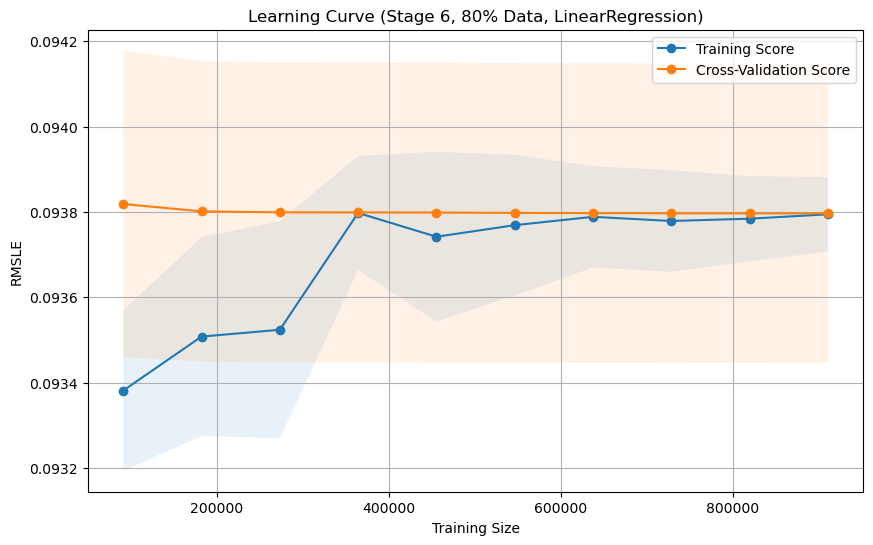

CPU times: total: 2 s
Wall time: 36.1 s


In [97]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 6', percent_data='80', transform = 'log_transform')

**Comparison with Lasso and ElasticNet Models**

In [98]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [99]:
%%time
messages_6 = model_rmsle(models, X_train, y_train, 'Stage 6', percent_data='80', transform = 'log_transform')[0]

Stage 6, 80% Data, RMSLE for LR: 0.0938 (0.0005)
Stage 6, 80% Data, RMSLE for LASSO: 0.7244 (0.0017)
Stage 6, 80% Data, RMSLE for EN: 0.7244 (0.0017)
CPU times: total: 5.97 s
Wall time: 1min 31s


The results from stage 6 indicate potential overfitting, with an RSMLE of 0.0938, after applying skewness transformation to the features `passenger_count`, `speed_osrm`, and `distance_osrm`. In contrast, stage 5 yielded an RSMLE of 0.3952 when applying skewness transformation only to the target variable `trip_duration`. Therefore, in the next stage, we will focus on transforming the target variable alone and avoid transforming the other features.


In [100]:
print(messages_5)
print(messages_6)

Stage 5, 80% Data, RMSLE for LR: 0.3952 (0.0014)
Stage 5, 80% Data, RMSLE for LASSO: 0.5244 (0.0014)
Stage 5, 80% Data, RMSLE for EN: 0.4493 (0.0011)
Stage 6, 80% Data, RMSLE for LR: 0.0938 (0.0005)
Stage 6, 80% Data, RMSLE for LASSO: 0.7244 (0.0017)
Stage 6, 80% Data, RMSLE for EN: 0.7244 (0.0017)


### Stage 7: Encoding Features

In [101]:
df = pd.read_csv('train_temp5.csv')

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137661 entries, 0 to 1137660
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   vendor_id                1137661 non-null  int64  
 1   passenger_count          1137661 non-null  int64  
 2   store_and_fwd_flag       1137661 non-null  object 
 3   distance_osrm            1137661 non-null  float64
 4   speed_osrm               1137661 non-null  float64
 5   pickup_datetime_month    1137661 non-null  int64  
 6   pickup_datetime_hour     1137661 non-null  int64  
 7   pickup_datetime_weekday  1137661 non-null  object 
 8   pickup_datetime_period   1137661 non-null  object 
 9   trip_duration            1137661 non-null  int64  
 10  pickup_cluster           1137661 non-null  int64  
 11  dropoff_cluster          1137661 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 104.2+ MB


In [103]:
df.isnull().sum().sum()

0

In [104]:
transformer = LogTripDurationTransformer()
df = transformer.transform(df)

In [105]:
df["pickup_datetime_weekday"] = df["pickup_datetime_weekday"].map({"Monday":1,"Tuesday":2,"Wednesday":3, 
                                                                   "Thursday":4, "Friday":5, "Saturday":6, 
                                                                   "Sunday":7}).astype("int")

**Dummy encoding, without cyclical encoding**

In [106]:
columns = ["pickup_cluster", "dropoff_cluster", "vendor_id","store_and_fwd_flag", "pickup_datetime_period",
           "pickup_datetime_hour", "pickup_datetime_weekday", "pickup_datetime_month"]
df = pd.get_dummies(df, columns=columns, dtype=int, drop_first=True)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137661 entries, 0 to 1137660
Data columns (total 49 columns):
 #   Column                                Non-Null Count    Dtype  
---  ------                                --------------    -----  
 0   passenger_count                       1137661 non-null  int64  
 1   distance_osrm                         1137661 non-null  float64
 2   speed_osrm                            1137661 non-null  float64
 3   trip_duration                         1137661 non-null  float64
 4   pickup_cluster_1                      1137661 non-null  int32  
 5   pickup_cluster_2                      1137661 non-null  int32  
 6   pickup_cluster_3                      1137661 non-null  int32  
 7   dropoff_cluster_1                     1137661 non-null  int32  
 8   dropoff_cluster_2                     1137661 non-null  int32  
 9   vendor_id_2                           1137661 non-null  int32  
 10  store_and_fwd_flag_Y                  1137661 non-null

In [108]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

In [109]:
baseline_model = LinearRegression()

In [110]:
%%time
messages_7 = model_rmsle(baseline_model, X_train, y_train, 'Stage 7', percent_data='80', transform = 'log_transform')[0]

Stage 7, 80% Data, RMSLE for LinearRegression: 0.3950 (0.0014)
CPU times: total: 2.2 s
Wall time: 1min 46s


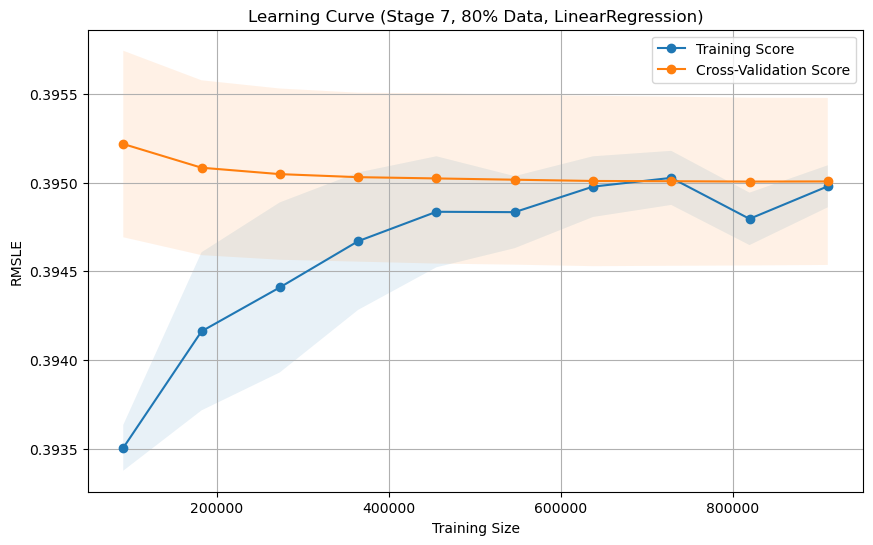

CPU times: total: 2.98 s
Wall time: 1min 17s


In [111]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 7', percent_data='80', transform = 'log_transform')

**Comparison with Lasso and ElasticNet Models**

In [112]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [113]:
%%time
messages_7 = model_rmsle(models, X_train, y_train, 'Stage 7', percent_data='80', transform = 'log_transform')[0]

Stage 7, 80% Data, RMSLE for LR: 0.3950 (0.0014)
Stage 7, 80% Data, RMSLE for LASSO: 0.5244 (0.0014)
Stage 7, 80% Data, RMSLE for EN: 0.4493 (0.0011)
CPU times: total: 7.59 s
Wall time: 3min 22s


- Cyclical Encoding (21 features, RMSLE: 0.3952): Cyclical encoding preserves the inherent cyclical nature of certain features, which is especially beneficial for data with repeating patterns (e.g., hours in a day, days of the week). Using only 20 features, this encoding keeps the model simpler, potentially allowing for faster training times and reduced memory usage. This efficiency is particularly advantageous when scaling to larger datasets.

- Dummy Encoding (49 features, RMSLE: 0.3950): In contrast, dummy encoding expands each category into separate features without capturing any cyclical relationships, resulting in a higher feature count of 48. The slightly lower RMSLE here may suggest a marginally better model fit. However, the increased feature count adds complexity to the model, requiring more computational resources and **risking overfitting**, especially with sparse categorical values.

In [114]:
print(messages_5)
print(messages_7)

Stage 5, 80% Data, RMSLE for LR: 0.3952 (0.0014)
Stage 5, 80% Data, RMSLE for LASSO: 0.5244 (0.0014)
Stage 5, 80% Data, RMSLE for EN: 0.4493 (0.0011)
Stage 7, 80% Data, RMSLE for LR: 0.3950 (0.0014)
Stage 7, 80% Data, RMSLE for LASSO: 0.5244 (0.0014)
Stage 7, 80% Data, RMSLE for EN: 0.4493 (0.0011)


I will choose **cyclical encoding** for the following reasons:
- Model simplicity and efficiency: By keeping the feature count at 21, cyclical encoding ensures a more compact feature set, lowering the computational load and enabling faster processing.
- Alignment with cyclical patterns: Since my data has cyclical elements, cyclical encoding aligns more naturally with these patterns, which may contribute to better generalization.


### Stage 8a: Feature Scaling - Standardization (Z-score normalization)

In [115]:
df = pd.read_csv('train_temp5.csv')

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137661 entries, 0 to 1137660
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   vendor_id                1137661 non-null  int64  
 1   passenger_count          1137661 non-null  int64  
 2   store_and_fwd_flag       1137661 non-null  object 
 3   distance_osrm            1137661 non-null  float64
 4   speed_osrm               1137661 non-null  float64
 5   pickup_datetime_month    1137661 non-null  int64  
 6   pickup_datetime_hour     1137661 non-null  int64  
 7   pickup_datetime_weekday  1137661 non-null  object 
 8   pickup_datetime_period   1137661 non-null  object 
 9   trip_duration            1137661 non-null  int64  
 10  pickup_cluster           1137661 non-null  int64  
 11  dropoff_cluster          1137661 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 104.2+ MB


In [117]:
cleaner = DataCleaner()
df = cleaner.transform(df)

4 duplicates found. Dropping duplicates.
No missing values found in the DataFrame.


In [118]:
transformer = LogTripDurationTransformer()
df = transformer.transform(df)

In [119]:
df = transform_encoding(df, 2)

In [120]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

**Standardization (Z-score normalization)**

In [121]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [122]:
X_train

array([[-0.50559574,  0.1875349 , -0.13328423, ..., -1.25232635,
        -1.88702079, -1.21827549],
       [-0.50559574, -0.31879694, -0.73897966, ...,  0.91397548,
         0.70204172, -0.48051009],
       [-0.50559574, -0.34178152, -0.4505545 , ...,  0.91397548,
        -0.39222486, -1.02059185],
       ...,
       [-0.50559574,  1.05215029,  0.9586854 , ..., -0.28823134,
        -0.39222486,  1.53510246],
       [-0.50559574, -0.69937535, -1.0939889 , ..., -0.28823134,
        -0.39222486,  1.53510246],
       [-0.50559574,  2.07391087,  1.69502566, ..., -1.25232635,
         0.70204172,  0.9950207 ]])

In [123]:
baseline_model = LinearRegression()

In [124]:
%%time
messages_8a = model_rmsle(baseline_model, X_train, y_train, 'Stage 8a', percent_data='80', transform = 'log_transform')[0]

Stage 8a, 80% Data, RMSLE for LinearRegression: 0.3952 (0.0014)
CPU times: total: 1.64 s
Wall time: 33.4 s


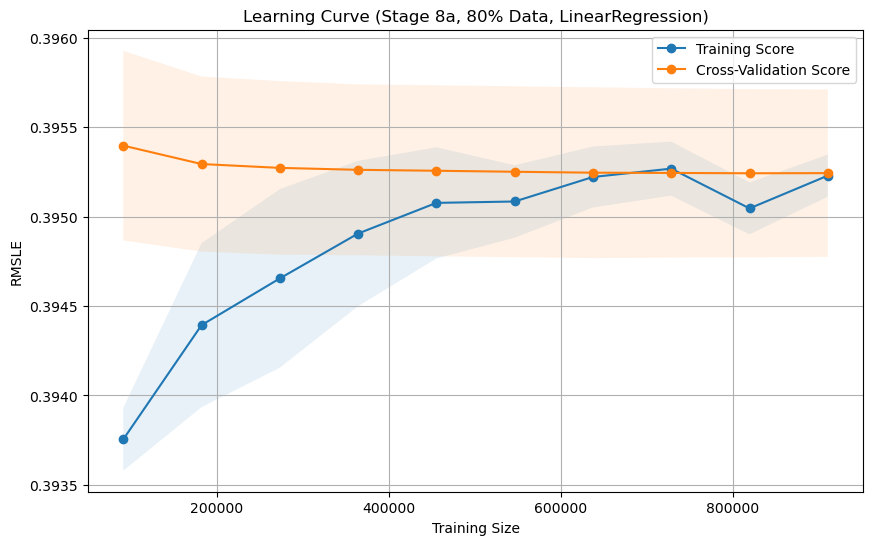

CPU times: total: 1.73 s
Wall time: 26.7 s


In [125]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 8a', percent_data='80', transform = 'log_transform')

**Comparison with Lasso and ElasticNet Models**

In [126]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [127]:
%%time
messages_8a = model_rmsle(models, X_train, y_train, 'Stage 8a', percent_data='80', transform = 'log_transform')[0]

Stage 8a, 80% Data, RMSLE for LR: 0.3952 (0.0014)
Stage 8a, 80% Data, RMSLE for LASSO: 0.7244 (0.0016)
Stage 8a, 80% Data, RMSLE for EN: 0.7244 (0.0016)
CPU times: total: 5.05 s
Wall time: 1min 6s


### Stage 8b: Feature Scaling - Min-Max Scaling

In [128]:
df = pd.read_csv('train_temp5.csv')

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137661 entries, 0 to 1137660
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   vendor_id                1137661 non-null  int64  
 1   passenger_count          1137661 non-null  int64  
 2   store_and_fwd_flag       1137661 non-null  object 
 3   distance_osrm            1137661 non-null  float64
 4   speed_osrm               1137661 non-null  float64
 5   pickup_datetime_month    1137661 non-null  int64  
 6   pickup_datetime_hour     1137661 non-null  int64  
 7   pickup_datetime_weekday  1137661 non-null  object 
 8   pickup_datetime_period   1137661 non-null  object 
 9   trip_duration            1137661 non-null  int64  
 10  pickup_cluster           1137661 non-null  int64  
 11  dropoff_cluster          1137661 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 104.2+ MB


In [130]:
cleaner = DataCleaner()
df = cleaner.transform(df)

4 duplicates found. Dropping duplicates.
No missing values found in the DataFrame.


In [131]:
transformer = LogTripDurationTransformer()
df = transformer.transform(df)

In [132]:
df = transform_encoding(df, 2)

In [133]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

**Min-Max Scaling**

In [134]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

In [135]:
X_train

array([[1.66666667e-01, 1.00939797e-01, 8.99577606e-02, ...,
        5.55111512e-17, 0.00000000e+00, 0.00000000e+00],
       [1.66666667e-01, 5.17078564e-02, 4.83463791e-02, ...,
        8.01937736e-01, 8.66025404e-01, 2.67949192e-01],
       [1.66666667e-01, 4.94730069e-02, 6.81612377e-02, ...,
        8.01937736e-01, 5.00000000e-01, 7.17967697e-02],
       ...,
       [1.66666667e-01, 1.85008564e-01, 1.64976264e-01, ...,
        3.56895868e-01, 5.00000000e-01, 1.00000000e+00],
       [1.66666667e-01, 1.47032435e-02, 2.39571830e-02, ...,
        3.56895868e-01, 5.00000000e-01, 1.00000000e+00],
       [1.66666667e-01, 2.84356960e-01, 2.15562968e-01, ...,
        5.55111512e-17, 8.66025404e-01, 8.03847577e-01]])

In [136]:
baseline_model = LinearRegression()

In [137]:
%%time
messages_8b = model_rmsle(baseline_model, X_train, y_train, 'Stage 8b', percent_data='80', transform = 'log_transform')[0]

Stage 8b, 80% Data, RMSLE for LinearRegression: 0.3952 (0.0014)
CPU times: total: 1.55 s
Wall time: 32 s


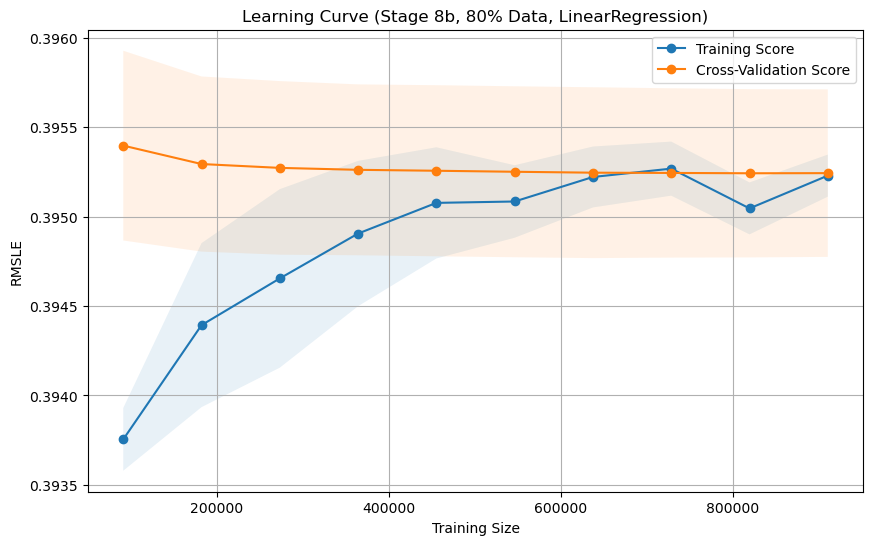

CPU times: total: 1.47 s
Wall time: 27.4 s


In [138]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 8b', percent_data='80', transform = 'log_transform')

**Comparison with Lasso and ElasticNet Models**

In [139]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [140]:
%%time
messages_8b = model_rmsle(models, X_train, y_train, 'Stage 8b', percent_data='80', transform = 'log_transform')[0]

Stage 8b, 80% Data, RMSLE for LR: 0.3952 (0.0014)
Stage 8b, 80% Data, RMSLE for LASSO: 0.7244 (0.0016)
Stage 8b, 80% Data, RMSLE for EN: 0.7244 (0.0016)
CPU times: total: 4.73 s
Wall time: 1min 5s


### Stage 8c: Feature Scaling - Robust Scaler

In [141]:
df = pd.read_csv('train_temp5.csv')

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137661 entries, 0 to 1137660
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   vendor_id                1137661 non-null  int64  
 1   passenger_count          1137661 non-null  int64  
 2   store_and_fwd_flag       1137661 non-null  object 
 3   distance_osrm            1137661 non-null  float64
 4   speed_osrm               1137661 non-null  float64
 5   pickup_datetime_month    1137661 non-null  int64  
 6   pickup_datetime_hour     1137661 non-null  int64  
 7   pickup_datetime_weekday  1137661 non-null  object 
 8   pickup_datetime_period   1137661 non-null  object 
 9   trip_duration            1137661 non-null  int64  
 10  pickup_cluster           1137661 non-null  int64  
 11  dropoff_cluster          1137661 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 104.2+ MB


In [143]:
cleaner = DataCleaner()
df = cleaner.transform(df)

4 duplicates found. Dropping duplicates.
No missing values found in the DataFrame.


In [144]:
transformer = LogTripDurationTransformer()
df = transformer.transform(df)

In [145]:
df = transform_encoding(df, 2)

In [146]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

**Robust Scaler**

In [147]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

In [148]:
X_train

array([[ 0.00000000e+00,  8.44845909e-01,  8.09070173e-02, ...,
        -4.45041868e-01, -2.36602540e+00, -3.66025404e-01],
       [ 0.00000000e+00,  4.30393199e-02, -4.82058071e-01, ...,
         5.54958132e-01,  3.03318571e-16,  0.00000000e+00],
       [ 0.00000000e+00,  6.64187035e-03, -2.13980607e-01, ...,
         5.54958132e-01, -1.00000000e+00, -2.67949192e-01],
       ...,
       [ 0.00000000e+00,  2.21401582e+00,  1.09584083e+00, ...,
         0.00000000e+00, -1.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00, -5.59629236e-01, -8.12022264e-01, ...,
         0.00000000e+00, -1.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  3.83203448e+00,  1.78023408e+00, ...,
        -4.45041868e-01,  0.00000000e+00,  7.32050808e-01]])

In [149]:
baseline_model = LinearRegression()

In [150]:
%%time
messages_8c = model_rmsle(baseline_model, X_train, y_train, 'Stage 8c', percent_data='80', transform = 'log_transform')[0]

Stage 8c, 80% Data, RMSLE for LinearRegression: 0.3952 (0.0014)
CPU times: total: 1.69 s
Wall time: 31.8 s


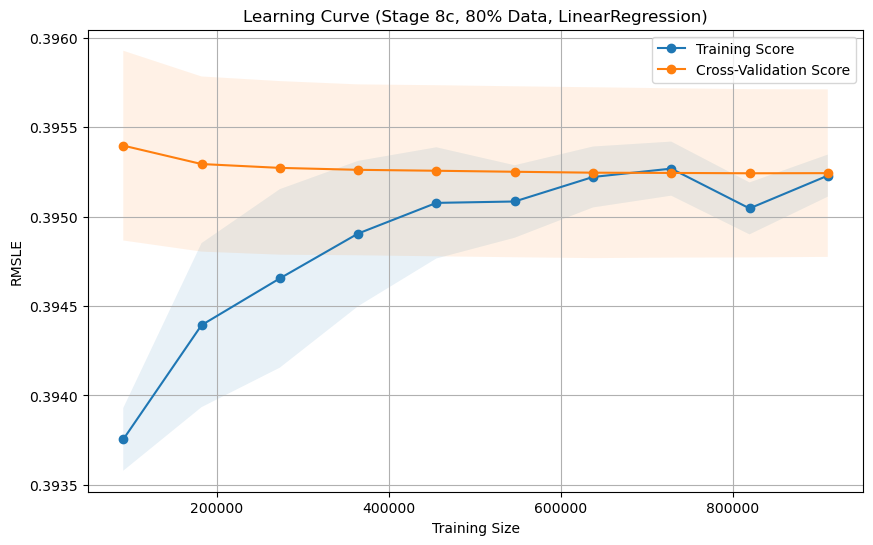

CPU times: total: 1.52 s
Wall time: 26.6 s


In [151]:
%%time
plot_learning_curve(baseline_model, X_train, y_train, 'Stage 8c', percent_data='80', transform = 'log_transform')

**Comparison with Lasso and ElasticNet Models**

In [152]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [153]:
%%time
messages_8c = model_rmsle(models, X_train, y_train, 'Stage 8c', percent_data='80', transform = 'log_transform')[0]

Stage 8c, 80% Data, RMSLE for LR: 0.3952 (0.0014)
Stage 8c, 80% Data, RMSLE for LASSO: 0.7244 (0.0016)
Stage 8c, 80% Data, RMSLE for EN: 0.6374 (0.0014)
CPU times: total: 4.75 s
Wall time: 1min 9s


The RMSLE from stages 8a-8c remains unchanged (RMSLE = 0.3950 ± 0.0014) even after applying StandardScaler, MinMaxScaler, or RobustScaler. This is likely because RMSLE is inherently less sensitive to feature scaling. It measures the ratio between the predicted and actual values using a logarithmic transformation, which reduces the impact of scaling on the error metric. Additionally, scaling does not alter the logarithmic relationship between the predictions and actual values, resulting in a similar RMSLE score regardless of the scaling technique applied.

Moreover, if the model used is not sensitive to feature scaling (e.g., tree-based models like Random Forest or Gradient Boosting), the predictions will not be significantly affected by scaling, leading to an unchanged RMSLE. Lastly, since the target variable itself remains unscaled, the relationship between the features and the target may already be well captured, making feature scaling less impactful on the final error metric.

Therefore, I will continue from stage 7 for the next stage.

In [154]:
print(messages_7)
print(messages_8a)
print(messages_8b)
print(messages_8c)

Stage 7, 80% Data, RMSLE for LR: 0.3950 (0.0014)
Stage 7, 80% Data, RMSLE for LASSO: 0.5244 (0.0014)
Stage 7, 80% Data, RMSLE for EN: 0.4493 (0.0011)
Stage 8a, 80% Data, RMSLE for LR: 0.3952 (0.0014)
Stage 8a, 80% Data, RMSLE for LASSO: 0.7244 (0.0016)
Stage 8a, 80% Data, RMSLE for EN: 0.7244 (0.0016)
Stage 8b, 80% Data, RMSLE for LR: 0.3952 (0.0014)
Stage 8b, 80% Data, RMSLE for LASSO: 0.7244 (0.0016)
Stage 8b, 80% Data, RMSLE for EN: 0.7244 (0.0016)
Stage 8c, 80% Data, RMSLE for LR: 0.3952 (0.0014)
Stage 8c, 80% Data, RMSLE for LASSO: 0.7244 (0.0016)
Stage 8c, 80% Data, RMSLE for EN: 0.6374 (0.0014)


### Stage 9a: Feature Selection - Baseline Model

In [155]:
df = pd.read_csv('train_temp5.csv')

In [156]:
test = pd.read_csv('test_temp.csv')

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137661 entries, 0 to 1137660
Data columns (total 12 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   vendor_id                1137661 non-null  int64  
 1   passenger_count          1137661 non-null  int64  
 2   store_and_fwd_flag       1137661 non-null  object 
 3   distance_osrm            1137661 non-null  float64
 4   speed_osrm               1137661 non-null  float64
 5   pickup_datetime_month    1137661 non-null  int64  
 6   pickup_datetime_hour     1137661 non-null  int64  
 7   pickup_datetime_weekday  1137661 non-null  object 
 8   pickup_datetime_period   1137661 non-null  object 
 9   trip_duration            1137661 non-null  int64  
 10  pickup_cluster           1137661 non-null  int64  
 11  dropoff_cluster          1137661 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 104.2+ MB


In [158]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291729 entries, 0 to 291728
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        291729 non-null  object 
 1   vendor_id                 291729 non-null  int64  
 2   passenger_count           291729 non-null  int64  
 3   pickup_longitude          291729 non-null  float64
 4   pickup_latitude           291729 non-null  float64
 5   dropoff_longitude         291729 non-null  float64
 6   dropoff_latitude          291729 non-null  float64
 7   store_and_fwd_flag        291729 non-null  object 
 8   distance_osrm             291728 non-null  float64
 9   speed_osrm                291728 non-null  float64
 10  pickup_datetime_month     291729 non-null  int64  
 11  pickup_datetime_hour      291729 non-null  int64  
 12  pickup_datetime_weekday   291729 non-null  object 
 13  pickup_datetime_period    291729 non-null  o

In [159]:
%%time
nyc_boundary_transformer = NYCWithinBoundaryTransformer(nyc_zone_file='NYC Taxi Zones.geojson', buffer_distance=500)
test = nyc_boundary_transformer.fit_transform(test)

I have removed 0.23% of the data outside the NYC boundary from the pickup and dropoff points in the dataset.
CPU times: total: 18.9 s
Wall time: 19.7 s


In [160]:
%%time
restrictor = RestrictDurationSpeedDistance()
test = restrictor.transform(test)

I have removed 2.34% of the outliers from the dataset.
Max trip_duration = 13694
Min trip_duration = 60
Max distance_osrm = 49.68
Min distance_osrm = 0.10
Max speed_osrm = 149.21
Min speed_osrm = 5.00
CPU times: total: 391 ms
Wall time: 393 ms


In [161]:
cleaner = DataCleaner()

In [162]:
df = cleaner.transform(df)

4 duplicates found. Dropping duplicates.
No missing values found in the DataFrame.


In [163]:
test = cleaner.transform(test)

No duplicates found in the DataFrame.
No missing values found in the DataFrame.


In [164]:
transformer = LogTripDurationTransformer()

In [165]:
df = transformer.transform(df)

In [166]:
test = transformer.transform(test)

In [167]:
transformer = PickupDropoffClusterTransformer(optimal_k_pickup=4, optimal_k_dropoff=3, random_state=rst)
transformer.fit(test)
test = transformer.transform(test)

In [168]:
cols_to_drop = ['id', 'dropoff_datetime_month', 'dropoff_datetime_weekday', 'dropoff_datetime_hour', 
                'dropoff_datetime_period']

In [169]:
test.drop(columns=cols_to_drop, axis=1, inplace=True)

In [170]:
test = test[df.columns]

In [171]:
df = transform_encoding(df, 2)
test = transform_encoding(test, 2)

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137657 entries, 0 to 1137656
Data columns (total 21 columns):
 #   Column                                Non-Null Count    Dtype  
---  ------                                --------------    -----  
 0   passenger_count                       1137657 non-null  int64  
 1   distance_osrm                         1137657 non-null  float64
 2   speed_osrm                            1137657 non-null  float64
 3   trip_duration                         1137657 non-null  float64
 4   pickup_cluster_1                      1137657 non-null  int32  
 5   pickup_cluster_2                      1137657 non-null  int32  
 6   pickup_cluster_3                      1137657 non-null  int32  
 7   dropoff_cluster_1                     1137657 non-null  int32  
 8   dropoff_cluster_2                     1137657 non-null  int32  
 9   vendor_id_2                           1137657 non-null  int32  
 10  store_and_fwd_flag_Y                  1137657 non-null

In [173]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284237 entries, 0 to 284236
Data columns (total 21 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   passenger_count                       284237 non-null  int64  
 1   distance_osrm                         284237 non-null  float64
 2   speed_osrm                            284237 non-null  float64
 3   trip_duration                         284237 non-null  float64
 4   pickup_cluster_1                      284237 non-null  int32  
 5   pickup_cluster_2                      284237 non-null  int32  
 6   pickup_cluster_3                      284237 non-null  int32  
 7   dropoff_cluster_1                     284237 non-null  int32  
 8   dropoff_cluster_2                     284237 non-null  int32  
 9   vendor_id_2                           284237 non-null  int32  
 10  store_and_fwd_flag_Y                  284237 non-null  int32  
 11  

In [174]:
df.to_csv('train_s9a.csv', index=False)
test.to_csv('test_s9a.csv', index=False)

---

In [211]:
df = pd.read_csv('train_s9a.csv')
test = pd.read_csv('test_s9a.csv')

In [212]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

X_test = test.drop(columns="trip_duration", axis=1)
y_test = test["trip_duration"]

In [213]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [214]:
messages = []

for name, model in models:
    
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Reverse log-transform predictions and test data
    y_pred = np.expm1(y_pred)
    y_test_transformed = np.expm1(y_test)

    # Clip predictions to non-negative values
    y_pred = np.clip(y_pred, 0, None)
    y_test_transformed = np.clip(y_test_transformed, 0, None)

    # Calculate RMSLE    
    rmsle_value_9a = rmsle(y_test_transformed, y_pred)
    msg = f'Stage 9a, 100% Data, RMSLE for {name}: {rmsle_value_9a:.4f}'
    print(msg)
    messages.append(msg)

messages_9a = '\n'.join(messages)

Stage 9a, 100% Data, RMSLE for LR: 0.3955
Stage 9a, 100% Data, RMSLE for LASSO: 0.5248
Stage 9a, 100% Data, RMSLE for EN: 0.4495


### Stage 9b: Feature Selection - Numerical-Numerical Feature Selection

In [215]:
df = pd.read_csv('train_s9a.csv')
test = pd.read_csv('test_s9a.csv')

In [216]:
X_train = df.drop(columns="trip_duration", axis=1)
y_train = df["trip_duration"]

X_test = test.drop(columns="trip_duration", axis=1)
y_test = test["trip_duration"]

Number of features=20
distance_osrm: 936518.971618
pickup_cluster_1: 77475.311045
dropoff_cluster_2: 66804.688230
pickup_cluster_3: 40589.669410
pickup_cluster_2: 19349.787210
weekday_cos: 5498.430549
hour_cos: 4072.047852
hour_sin: 3063.059036
month_cos: 2957.890802
pickup_datetime_period_Early Morning: 2787.886035
month_sin: 910.789890
pickup_datetime_period_Evening: 711.891626
store_and_fwd_flag_Y: 558.627766
pickup_datetime_period_Morning: 554.124837
dropoff_cluster_1: 417.700985
speed_osrm: 380.883409
pickup_datetime_period_Night: 323.967394
passenger_count: 234.853519
vendor_id_2: 28.802402
weekday_sin: 5.073370


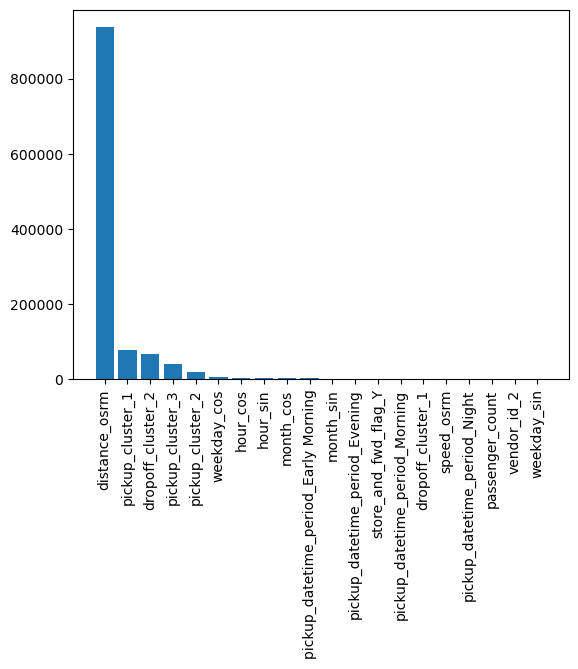

In [217]:
k = 'all'

X_train_fs, X_test_fs, fs, k = select_features(X_train, y_train, X_test, k=k)

sorted_indices = np.argsort(fs.scores_)[::-1]

if k == 'all':
    k = len(X_train.columns)
top_k_indices = sorted_indices[:k]  # Limit to the top k features
print(f'Number of features={k}')

for i in top_k_indices:
    print('%s: %f' % (X_train.columns[i], fs.scores_[i]))

sorted_scores = fs.scores_[top_k_indices]

plt.bar(range(len(sorted_scores)), sorted_scores)
plt.xticks(range(len(sorted_scores)), X_train.columns[top_k_indices], rotation=90)
plt.show()

In [218]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet())
]

In [219]:
%%time
for name, model in models:    
    for k in range(8, 21):
        # Be careful not to overwrite variables in the loop
        X_train_fs, X_test_fs, fs, selected_k = select_features(X_train, y_train, X_test, k)

        model.fit(X_train_fs, y_train)

        y_pred = model.predict(X_test_fs)

        y_pred = np.expm1(y_pred)
        y_test_expm1 = np.expm1(y_test)
        
        y_pred = np.clip(y_pred, 0, None)
        y_test_expm1 = np.clip(y_test_expm1, 0, None)

        rmsle_value = rmsle(y_test_expm1, y_pred)
        message = f'Stage 9b, 100% Data, RMSLE for {name} (k = {selected_k}): {rmsle_value:.4f}'

        # Print results
        print(message)

Stage 9b, 100% Data, RMSLE for LR (k = 8): 0.5099
Stage 9b, 100% Data, RMSLE for LR (k = 9): 0.5092
Stage 9b, 100% Data, RMSLE for LR (k = 10): 0.5091
Stage 9b, 100% Data, RMSLE for LR (k = 11): 0.5091
Stage 9b, 100% Data, RMSLE for LR (k = 12): 0.5091
Stage 9b, 100% Data, RMSLE for LR (k = 13): 0.5091
Stage 9b, 100% Data, RMSLE for LR (k = 14): 0.5088
Stage 9b, 100% Data, RMSLE for LR (k = 15): 0.5110
Stage 9b, 100% Data, RMSLE for LR (k = 16): 0.3955
Stage 9b, 100% Data, RMSLE for LR (k = 17): 0.3955
Stage 9b, 100% Data, RMSLE for LR (k = 18): 0.3955
Stage 9b, 100% Data, RMSLE for LR (k = 19): 0.3955
Stage 9b, 100% Data, RMSLE for LR (k = 20): 0.3955
Stage 9b, 100% Data, RMSLE for LASSO (k = 8): 0.5683
Stage 9b, 100% Data, RMSLE for LASSO (k = 9): 0.5683
Stage 9b, 100% Data, RMSLE for LASSO (k = 10): 0.5683
Stage 9b, 100% Data, RMSLE for LASSO (k = 11): 0.5683
Stage 9b, 100% Data, RMSLE for LASSO (k = 12): 0.5683
Stage 9b, 100% Data, RMSLE for LASSO (k = 13): 0.5683
Stage 9b, 100% Da

Based on the feature selection results, it appears that setting **k=16** is optimal. This is because the RMSLE score remains stable from k=16 through k=20, indicating that increasing the number of features beyond 16 does not significantly enhance model performance. This stability suggests that k=16 captures the most relevant features while avoiding potential overfitting or diminishing returns from including additional features.

---

In [227]:
messages_9b = 'messages_9a.replace('9a', '9b') 

In [244]:
print("==================== SUMMARY ====================")
# print("\n========== Stage 0: Baseline Model")
# print(messages_0)
# print("\n========== Stage 1: Adding distance_osrm Feature")
# print(messages_1)
# print("\n========== Stage 2: Adding speed_osrm Feature")
# print(messages_2)
print("\n========== Stage 3: Restricting the boundary to within NYC")
print(messages_3)
print("\n========== Stage 4a: Applying sensible restrictions to trip_duration, speed_osrm, and distance_osrm ---> Failed, RMSLE increased")
print(f"{messages_4a}")
print("\n========== Stage 4b: Stage 3 with Log Transformation")
print(messages_4b)
print("\n========== Stage 4c: Applying sensible restrictions to trip_duration, speed_osrm, and distance_osrm with Log Transformation")
print(messages_4c)
print("\n========== Stage 4d: Final Result - Applying sensible restrictions to trip_duration, speed_osrm, and distance_osrm with Log Transformation")
print(messages_4d)
print("\n========== Stage 5: Replacing pickup_longitude, pickup_latitude with pickup_cluster and dropoff_longitude, dropoff_latitude with dropoff_cluster")
print(messages_5)
print("\n========== Stage 6: Skewness Transformation ---> Failed, probably due to overfitting (RMSLE too small for LR) and increased RMSLE for LASSO and ElasticNet") 
print(f"{messages_6}")
print("\n========== Stage 7: Encoding Features ---> Select cyclical encoding instead of dummy encoding")
print(messages_7)
print("\n========== Stage 8a: Feature Scaling - Standardization (Z-score normalization) ---> Failed, with no effect or an increase in RMSLE") 
print(messages_8a)
print("\n========== Stage 8b: Feature Scaling - Min-Max Scaling ---> Failed, with no effect or an increase in RMSLE")
print(messages_8b)
print("\n========== Stage 8c: Feature Scaling - Robust Scaler ---> Failed, with no effect or an increase in RMSLE")
print(messages_8c)
print("\n========== Stage 9a: Feature Selection - Baseline Model")
print(messages_9a)
print("\n========== Stage 9b: Feature Selection - Numerical-Numerical Feature Selection ---> Potential optimal number of features: k = 16") 
print(messages_9b)

==================== SUMMARY ====================

========== Stage 3: Restricting the boundary to within NYC
Stage 3, 80% Data, RMSLE for LR: 0.6027 (0.0023)
Stage 3, 80% Data, RMSLE for LASSO: 0.6091 (0.0024)
Stage 3, 80% Data, RMSLE for EN: 0.6139 (0.0025)

========== Stage 4a: Applying sensible restrictions to trip_duration, speed_osrm, and distance_osrm ---> Failed, RMSLE increased
Stage 4a, 80% Data, RMSLE for LR: 1.5548 (0.0191)
Stage 4a, 80% Data, RMSLE for LASSO: 1.5478 (0.0201)
Stage 4a, 80% Data, RMSLE for EN: 1.4725 (0.0196)

========== Stage 4b: Stage 3 with Log Transformation
Stage 4b, 80% Data, RMSLE for LR: 0.5715 (0.0027)
Stage 4b, 80% Data, RMSLE for LASSO: 0.6325 (0.0026)
Stage 4b, 80% Data, RMSLE for EN: 0.6070 (0.0028)

========== Stage 4c: Applying sensible restrictions to trip_duration, speed_osrm, and distance_osrm with Log Transformation
Stage 4c, 80% Data, RMSLE for LR: 0.4392 (0.0027)
Stage 4c, 80% Data, RMSLE for LASSO: 0.5520 (0.0027)
Stage 4c, 80% Data, RM

In [257]:
stop_here = True

if stop_here:
    raise RuntimeError("Execution stopped manually.")

RuntimeError: Execution stopped manually.

<div id="pipline">
    <div style="font-size:20pt;font-weight:700;padding:20px 0;line-height:1.2">5.2 Pipeline</div>
</div>

I have run the following models in the background (not in this notebook) using cross-validation:

```
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('SVR', SVR()),
    ('AB', AdaBoostRegressor()),
    ('GBM', GradientBoostingRegressor()),
    ('RF', RandomForestRegressor()),
    ('ET', ExtraTreesRegressor()),
    ('XGBR', XGBRegressor()),
    ('LGBM', LGBMRegressor()),
    ('CAT', CatBoostRegressor())
]
```

The results indicate that only Linear Regression, Lasso, and ElasticNet models align well with the dataset. These models demonstrated effective performance, likely due to the underlying linear relationships in the data. In contrast, the other models, including KNN, Decision Trees, and various ensemble methods, appear to be overfitting, as indicated by their RMSLE scores being around <0.1. This suggests they may be capturing noise rather than the true patterns in the data.

Given these findings, I will proceed with Linear Regression, Lasso, and ElasticNet into the next stage of my analysis.

In [2]:
df = pd.read_csv("distance_osrm.csv")

In [3]:
pipeline = Pipeline([
    ('speed_calculator', SpeedCalculator()),
    ('datetime_transformer', DateTimeTransformer()),
    ('nyc_boundary_transformer', NYCWithinBoundaryTransformer(nyc_zone_file='NYC Taxi Zones.geojson', buffer_distance=500)),
    ('restrictor', RestrictDurationSpeedDistance()),
    ('cleaner', DataCleaner()),
    ('pickdrop_cluster', PickupDropoffClusterTransformer(optimal_k_pickup=4, optimal_k_dropoff=3, random_state=rst)),
    ('log_transform', LogTripDurationTransformer()),
    ('encoding', TransformEncoding()),
    ('feature_dropper', FeatureDropper())
])

In [4]:
%%time
df = pipeline.fit_transform(df)

I have removed 0.23% of the data outside the NYC boundary from the pickup and dropoff points in the dataset.
I have removed 2.30% of the outliers from the dataset.
Max trip_duration = 20400
Min trip_duration = 60
Max distance_osrm = 55.28
Min distance_osrm = 0.10
Max speed_osrm = 149.79
Min speed_osrm = 5.00
No duplicates found in the DataFrame.
No missing values found in the DataFrame.
CPU times: total: 3min 43s
Wall time: 3min 40s


---

In [5]:
df.to_csv('top_models.csv', index=False)

---

In [2]:
from utils import *
df = pd.read_csv("top_models.csv")

---

In [3]:
X = df.drop(columns="trip_duration", axis=1)
y = df["trip_duration"]

In [4]:
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
]

In [5]:
%%time
messages_pipeline, names, results = model_rmsle(models, X, y, 'Pipeline', percent_data='100', transform = 'log_transform')

Pipeline, 100% Data, RMSLE for LR: 0.3953 (0.0011)
Pipeline, 100% Data, RMSLE for LASSO: 0.5245 (0.0009)
Pipeline, 100% Data, RMSLE for EN: 0.4493 (0.0008)
CPU times: total: 7.03 s
Wall time: 1min 44s


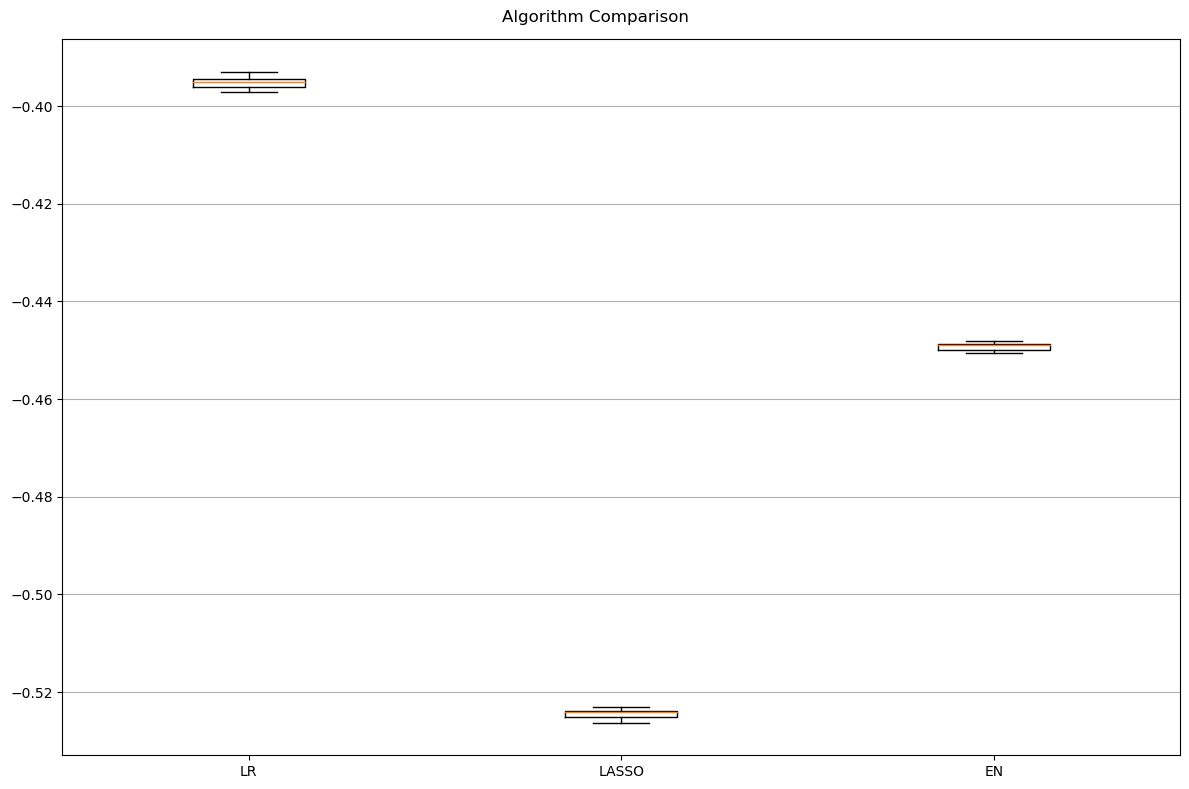

CPU times: total: 484 ms
Wall time: 1.12 s


In [6]:
%%time
plot_algorithm_comparison(names, results)

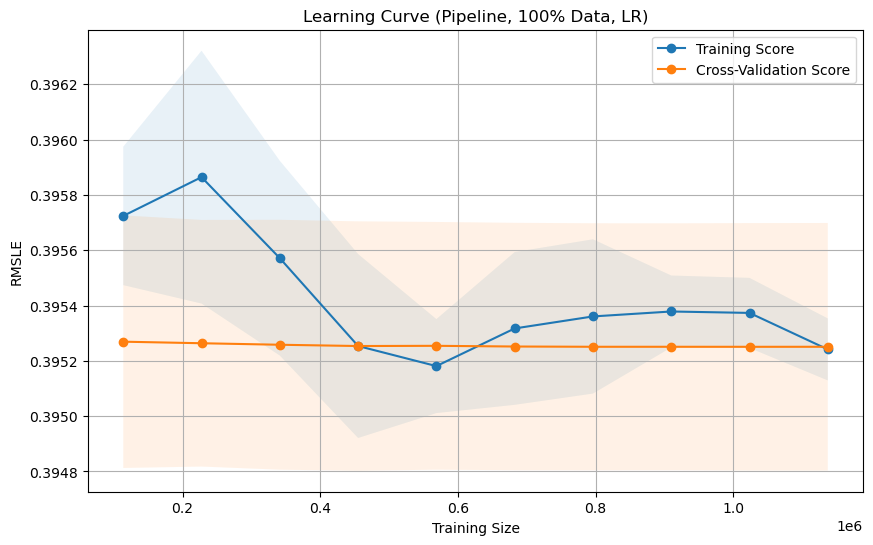

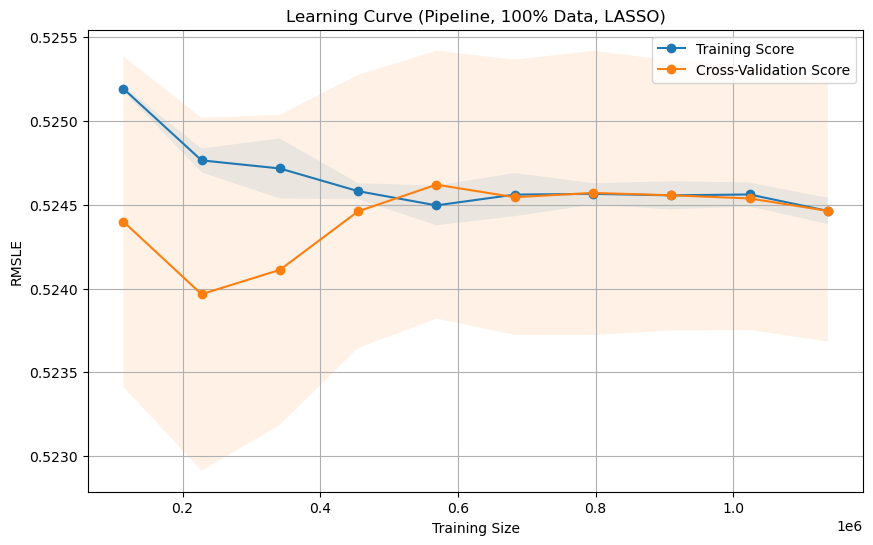

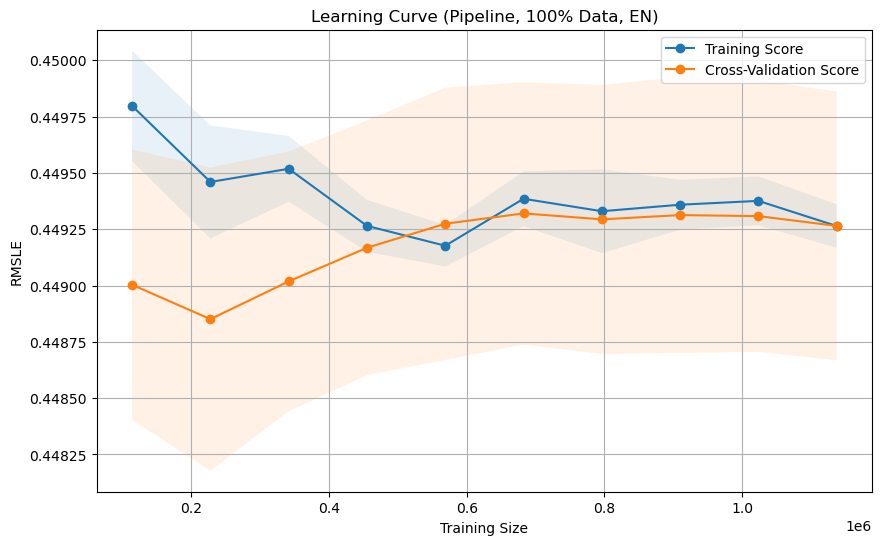

CPU times: total: 4.5 s
Wall time: 1min 19s


In [7]:
%%time
plot_learning_curve(models, X, y, 'Pipeline', percent_data='100', transform = 'log_transform')

In [8]:
stop_here = True

if stop_here:
    raise RuntimeError("Execution stopped manually.")

RuntimeError: Execution stopped manually.

<div id="hyperoptz">
    <div style="font-size:20pt;font-weight:700;padding:20px 0;line-height:1.2">5.3 Hyperparameter Optimization</div>
</div>

In [2]:
df = pd.read_csv("top_models.csv")

In [3]:
X = df.drop(columns="trip_duration", axis=1)
y = df["trip_duration"]

In [4]:
models = [
    ('LinearRegression', Pipeline([('selectkbest', SelectKBest(score_func=f_classif)), ('scaler', None), ('LR', LinearRegression())])),
    ('Lasso', Pipeline([('selectkbest', SelectKBest(score_func=f_classif)), ('scaler', None), ('LASSO', Lasso())])),
    ('ElasticNet', Pipeline([('selectkbest', SelectKBest(score_func=f_classif)), ('scaler', None), ('EN', ElasticNet())])),
]

In [5]:
param_grid_lr = {
    'LR__fit_intercept': [True, False],
    'selectkbest__k': range(14, 21),
    'scaler': [None, StandardScaler()]
}

param_grid_lasso = {
    'LASSO__alpha': [0.1, 1, 10],
    'LASSO__max_iter': [1000],
    'LASSO__fit_intercept': [True],
    'selectkbest__k': range(14, 21),
    'scaler': [None, StandardScaler()]
}

param_grid_en = {
    'EN__alpha': [0.1, 1, 10],
    'EN__l1_ratio': [0.1, 0.5],
    'EN__max_iter': [1000],
    'EN__fit_intercept': [True],
    'selectkbest__k': range(14, 21),
    'scaler': [None, StandardScaler()]
}

In [6]:
param_grids = {
    'LinearRegression': param_grid_lr,
    'Lasso': param_grid_lasso,
    'ElasticNet': param_grid_en,
}

Total fit = number of fold (cv) * the number of different hyperparameter configurations

- LR = (5) x (2x7x2) = 140 fits
- LASSO = (5) x (3x7x2) = 210 fits
- EN = (5) x (3x2x7x2) = 420 fits

In [7]:
best_model_name, best_estimator, best_params, best_score, results, names = run_grid_search(models, param_grids, 
                                                                                           X, y, transform = 'log_transform')

Starting grid search for LR_Model
Fitting 5 folds for each of 28 candidates, totalling 140 fits

Model: LR_Model
Best estimator for LR_Model: Pipeline(steps=[('selectkbest', SelectKBest(k=20)), ('scaler', None),
                ('LR', LinearRegression())])
Best parameters for LR_Model: {'LR__fit_intercept': True, 'scaler': None, 'selectkbest__k': 20}
Best RMSLE score for LR_Model: 0.3952
Time taken for LR_Model: 29.05 minutes

Starting grid search for LASSO_Model
Fitting 5 folds for each of 42 candidates, totalling 210 fits

Model: LASSO_Model
Best estimator for LASSO_Model: Pipeline(steps=[('selectkbest', SelectKBest(k=14)), ('scaler', None),
                ('LASSO', Lasso(alpha=0.1))])
Best parameters for LASSO_Model: {'LASSO__alpha': 0.1, 'LASSO__fit_intercept': True, 'LASSO__max_iter': 1000, 'scaler': None, 'selectkbest__k': 14}
Best RMSLE score for LASSO_Model: 0.4160
Time taken for LASSO_Model: 40.86 minutes

Starting grid search for EN_Model
Fitting 5 folds for each of 84 candi

In [11]:
results

[GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('selectkbest', SelectKBest()),
                                        ('scaler', None),
                                        ('LR', LinearRegression())]),
              n_jobs=-1,
              param_grid={'LR__fit_intercept': [True, False],
                          'scaler': [None, StandardScaler()],
                          'selectkbest__k': range(14, 21)},
              scoring=make_scorer(<lambda>, greater_is_better=False), verbose=2),
 GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('selectkbest', SelectKBest()),
                                        ('scaler', None), ('LASSO', Lasso())]),
              n_jobs=-1,
              param_grid={'LASSO__alpha': [0.1, 1, 10],
                          'LASSO__fit_intercept': [True],
                          'LASSO__max_iter': [1000],
                          'scal

In [8]:
output_list = [best_model_name, best_estimator, best_params, best_score, results, names]

file_path = 'grid_search_results.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(output_list, file)

print(f"Complete results saved to {file_path} as a list.")

AttributeError: Can't pickle local object 'run_grid_search.<locals>.<lambda>'

In [ ]:
stop_here = True

if stop_here:
    raise RuntimeError("Execution stopped manually.")

In [ ]:
file_path = 'grid_search_results.pkl'

In [ ]:
with open(file_path, 'rb') as file:
    loaded_list = pickle.load(file)

best_model_name, best_estimator, best_params, best_score, results, names = loaded_list

<div id="finalmodel">
    <div style="font-size:20pt;font-weight:700;padding:20px 0;line-height:1.2">5.4 Final Model</div>
</div>

In [ ]:
model = best_model_name(**best_params)

In [ ]:
df = pd.read_csv("top_models.csv")

In [ ]:
X = df.drop(columns="trip_duration", axis=1)
y = df["trip_duration"]

In [ ]:
model.fit(X, y)

In [ ]:
y_pred = model.predict(X_test)

if transform == 'log_transform':
    # Reverse the log transformation to get the original scale of trip duration
    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test) 

y_pred = np.clip(y_pred, 0, None)
y_test = np.clip(y_test, 0, None)

rmsle_value = rmsle(y_test, y_pred)
print(f'{model_name} RMSLE (100% Data, {stage}): {rmsle_value:.4f}')